<a href="https://colab.research.google.com/github/modichirag/flowpm/blob/cleanup/flowpm_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet git+https://github.com/modichirag/flowpm.git;

     |████████████████████████████████| 368kB 5.7MB/s 


In [1]:
%pylab inline
import tensorflow as tf
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow_probability as tfp
tfp.__version__, tf.__version__

('0.12.1', '2.4.1')

In [3]:
# Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 1.0       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 10        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 32        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 16        #Batch size, how many independent Universes to simulate

In [10]:
import flowpm
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import cosmo

@tf.function
def simulation(om, s8):
    
    cosmo['sigma8'] = s8
    cosmo['Omega0_m'] = om
    
    stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

    initial_conditions = flowpm.linear_field(N,          # size of the cube
                                             L,          # Physical size of the cube
                                             lambda k: linear_matter_power(cosmo, k), # Initial powerspectrum
                                             batch_size=16)

    # Sample particles
    state = flowpm.lpt_init(initial_conditions, a0)   

    # Evolve particles down to z=0
    final_state = flowpm.nbody(state, stages, 32)         

    # Retrieve final density field
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
    
    return final_field

In [11]:
simulation(0.3075, 0.8159)

NotImplementedError: in user code:

    <ipython-input-10-550446862029>:13 simulation  *
        initial_conditions = flowpm.linear_field(N,          # size of the cube
    /home/francois/repo/flowpm/flowpm/tfpm.py:57 linear_field  *
        pkmesh = pk(kmesh)
    /home/francois/repo/flowpm/flowpm/tfpower.py:189 linear_matter_power  *
        g = bkgrd.D1(cosmo, a)
    /home/francois/repo/flowpm/flowpm/tfbackground.py:607 D1  *
        cache = maybe_compute_ODE(cosmo)
    /home/francois/repo/flowpm/flowpm/tfbackground.py:575 maybe_compute_ODE  *
        cache = odesolve_func(cosmo, a)
    /home/francois/repo/flowpm/flowpm/tfbackground.py:541 odesolve_func  *
        results = solver.solve(growth_ode,a[0],
    /home/francois/.local/lib/python3.9/site-packages/tensorflow_probability/python/math/ode/base.py:475 solve  **
        return gradient_helper(*(flat_initial_state + flat_constants))
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/custom_gradient.py:261 __call__
        return self._d(self._f, a, k)
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/custom_gradient.py:217 decorated
        return _graph_mode_decorator(wrapped, args, kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/custom_gradient.py:330 _graph_mode_decorator
        result, grad_fn = f(*args)
    /home/francois/.local/lib/python3.9/site-packages/tensorflow_probability/python/math/ode/base.py:231 gradient_helper
        results = self._solve(
    /home/francois/.local/lib/python3.9/site-packages/tensorflow_probability/python/math/ode/bdf.py:574 _solve
        jacobian_mat=tf.zeros([p.num_odes, p.num_odes],
    /usr/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2868 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /usr/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    /usr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3030 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /usr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:852 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (bdf/Size:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


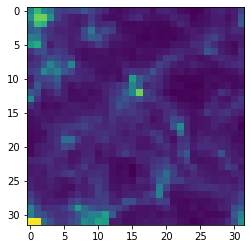

In [6]:
imshow(final_field[0].numpy().sum(axis=0))

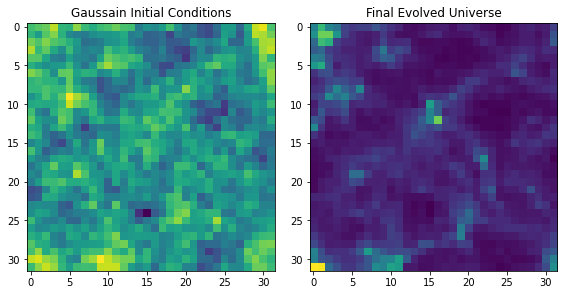

In [7]:
ib = 0  #index of the Universe in the batch

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(initial_conditions[ib].numpy().sum(axis=0))
ax[0].set_title('Gaussain Initial Conditions')
ax[1].imshow(final_field[ib].numpy().sum(axis=0))
ax[1].set_title('Final Evolved Universe')
plt.tight_layout()
plt.show()



No handles with labels found to put in legend.


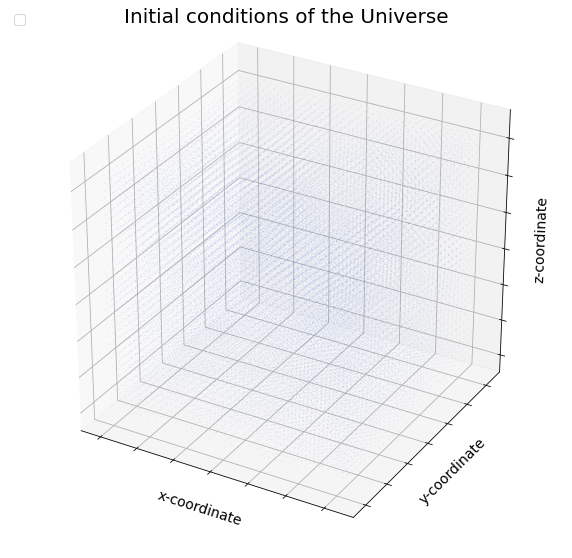

In [8]:
#Create figure
#Need to convert to physical coordinates
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(state[0, 0,:,0],state[0, 0,:,1], state[0, 0,:,2],color="royalblue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Initial conditions of the Universe\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
plt.savefig('3dinitial.png', dpi=1200)

No handles with labels found to put in legend.


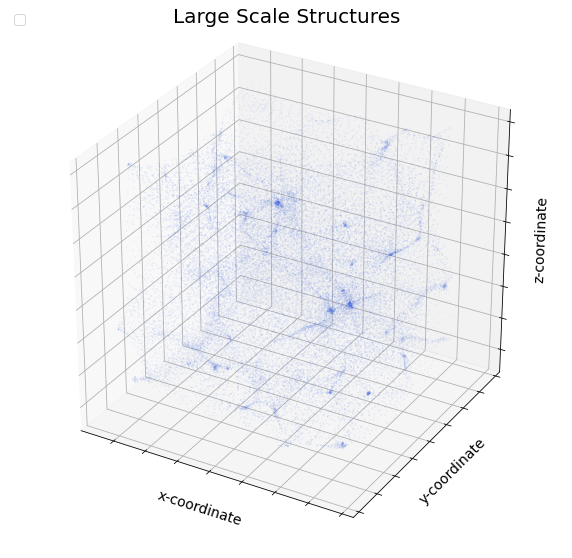

In [9]:
#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(final_state[0, 0,:,0],final_state[0, 0,:,1], final_state[0, 0,:,2],color="royalblue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
plt.savefig('3dfinal.png', dpi=1200)